# Market Data Investigation & Analysis

**Objective**: Comprehensive analysis of historical market data for arbitrage strategy development

**Data Source**: Historical trades from Binance, Coinbase, and Kraken converted to 1-second OHLCV bars

**Analysis Focus**:
- Data quality and completeness
- Price movement patterns and volatility
- Arbitrage opportunity identification
- Statistical modeling and insights

## 1. Setup and Dependencies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from scipy import signal
import warnings


# Financial analysis libraries
#import pandas_ta as ta
import empyrical as ep

In [8]:
warnings.filterwarnings('ignore')
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Data Loading and Initial Exploration

In [9]:
# Load the OHLCV data
# Note: Update the file path to match your actual data file
data_file = "data/binance_btc-usdt_1s_ohlcv.parquet"

try:
    df = pd.read_parquet(data_file)
    print(f"✅ Data loaded successfully from {data_file}")
    print(f"📊 Shape: {df.shape}")
    print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
except FileNotFoundError:
    print(f"❌ File not found: {data_file}")
    print("Please update the data_file variable to point to your actual data file")
    # Create sample data for demonstration
    dates = pd.date_range('2024-01-01', '2024-01-02', freq='1S')
    np.random.seed(42)
    sample_data = {
        'timestamp': dates,
        'open': np.random.normal(45000, 1000, len(dates)),
        'high': np.random.normal(45500, 1000, len(dates)),
        'low': np.random.normal(44500, 1000, len(dates)),
        'close': np.random.normal(45000, 1000, len(dates)),
        'volume': np.random.exponential(100, len(dates))
    }
    df = pd.DataFrame(sample_data)
    print("📝 Using sample data for demonstration")

# Display basic info
print("\n📋 Data Info:")
print(df.info())

print("\n🔍 First few rows:")
display(df.head())

print("\n📊 Statistical Summary:")
display(df.describe())

✅ Data loaded successfully from data/binance_btc-usdt_1s_ohlcv.parquet
📊 Shape: (86400, 6)
📅 Date range: 2024-01-01 00:00:00+00:00 to 2024-01-01 23:59:59+00:00

📋 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  86400 non-null  datetime64[ns, UTC]
 1   open       81947 non-null  float64            
 2   high       81947 non-null  float64            
 3   low        81947 non-null  float64            
 4   close      81947 non-null  float64            
 5   volume     86400 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 4.0 MB
None

🔍 First few rows:


,timestamp,open,high,low,close,volume
0,2024-01-01 00:00:00+00:00,42283.58,42283.59,42283.58,42283.58,0.07625
1,2024-01-01 00:00:01+00:00,42283.59,42283.59,42283.58,42283.58,1.37528
2,2024-01-01 00:00:02+00:00,42283.58,42283.59,42283.58,42283.58,0.18867
3,2024-01-01 00:00:03+00:00,42283.58,42283.59,42283.58,42283.59,0.83012
4,2024-01-01 00:00:04+00:00,42283.58,42283.59,42283.58,42283.59,0.23809



📊 Statistical Summary:


,open,high,low,close,volume
count,81947.000000,81947.000000,81947.000000,81947.000000,86400.000000
mean,42811.659045,42811.951659,42811.388708,42811.681304,0.312298
std,462.004704,462.167285,461.865782,462.025073,1.342400
min,42180.810000,42189.240000,42180.770000,42187.510000,0.000000
25%,42489.000000,42489.010000,42489.000000,42489.000000,0.006070
50%,42667.100000,42667.860000,42666.600000,42667.100000,0.038830
75%,43036.300000,43037.495000,43036.290000,43036.300000,0.166033
max,44184.000000,44184.100000,44183.990000,44184.000000,89.132040


## 3. Data Quality Assessment

In [10]:
# Check for missing values
print("🔍 Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
display(missing_df)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔄 Duplicate rows: {duplicates}")

# Check data types and convert timestamp if needed
if 'timestamp' in df.columns:
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    print("\n✅ Timestamp index set successfully")

# Verify OHLC relationships
print("\n🔍 OHLC Data Quality Checks:")
print(f"High >= Low violations: {(df['high'] < df['low']).sum()}")
print(f"Open/Close within High-Low range: {((df['open'] >= df['low']) & (df['open'] <= df['high']) & (df['close'] >= df['low']) & (df['close'] <= df['high'])).sum()}")
print(f"Zero volume bars: {(df['volume'] == 0).sum()}")
print(f"Negative prices: {((df[['open', 'high', 'low', 'close']] < 0).any(axis=1)).sum()}")

🔍 Missing Values Analysis:


,Missing Count,Missing Percentage
timestamp,0,0.000000
open,4453,5.153935
high,4453,5.153935
low,4453,5.153935
close,4453,5.153935
volume,0,0.000000



🔄 Duplicate rows: 0

✅ Timestamp index set successfully

🔍 OHLC Data Quality Checks:
High >= Low violations: 0
Open/Close within High-Low range: 81947
Zero volume bars: 4453
Negative prices: 0


## 4. Time Series Analysis

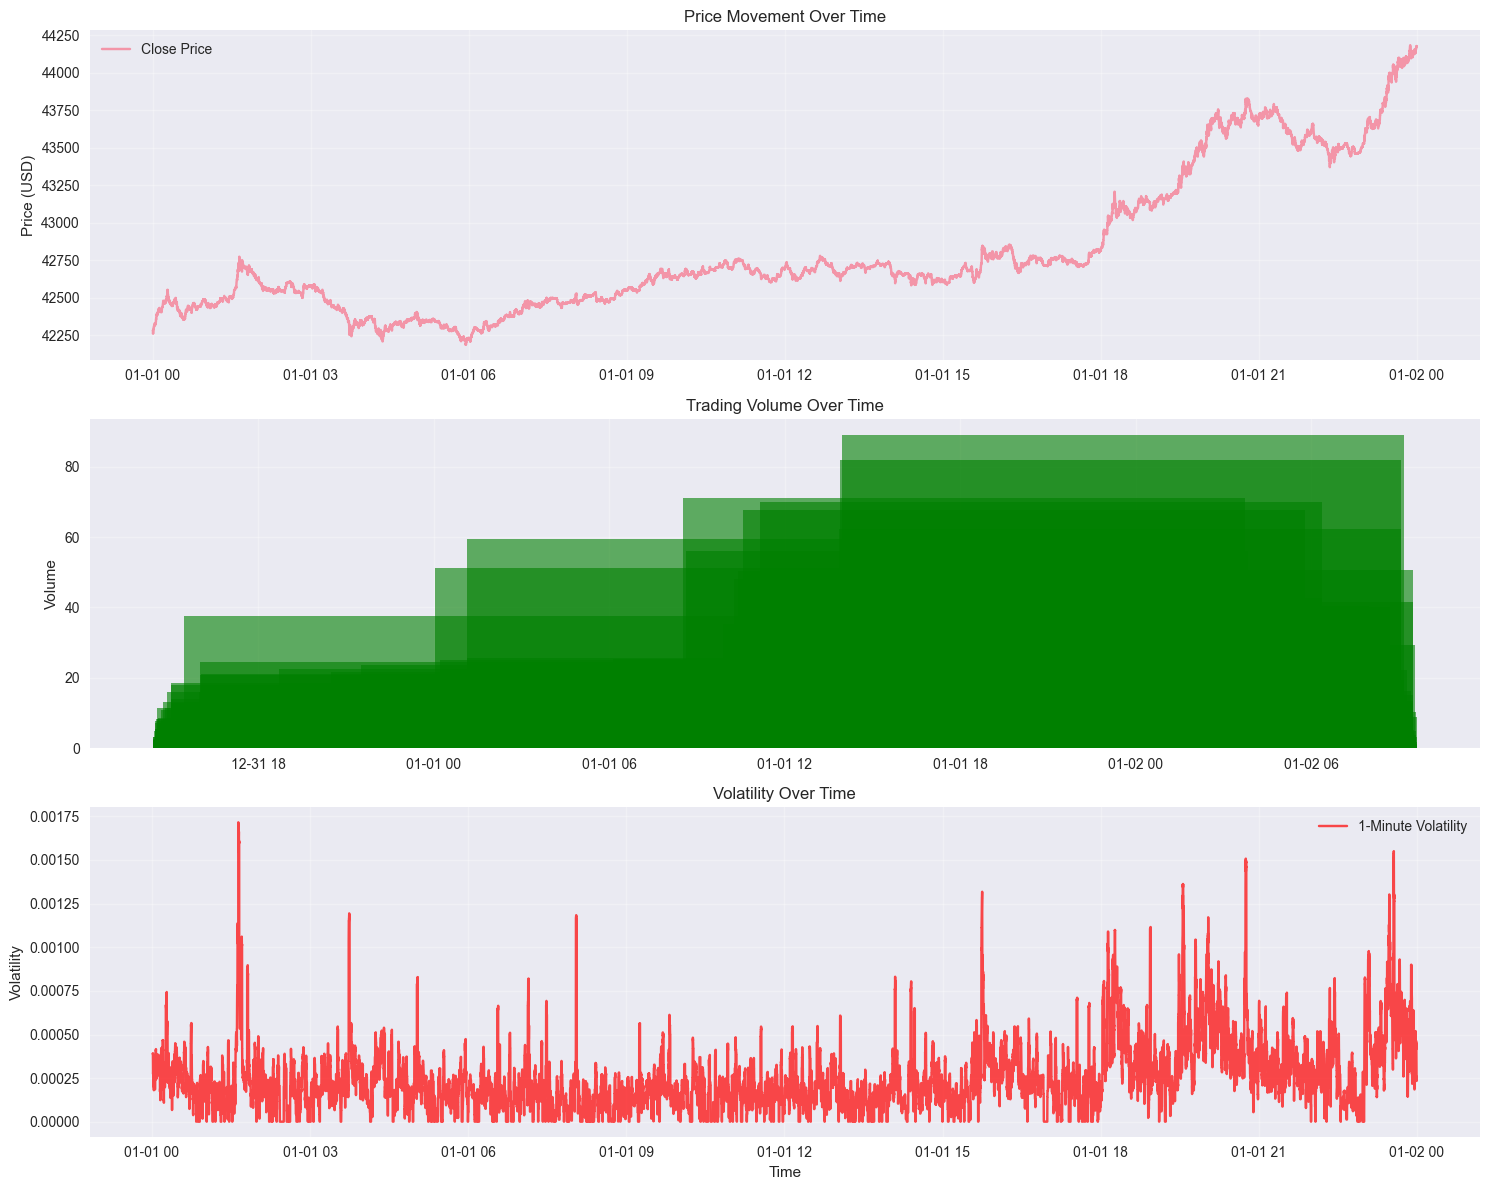

📊 Returns Statistics:


count    8.639900e+04
mean     5.086051e-07
std      4.297379e-05
min     -1.116391e-03
25%     -2.291516e-07
50%      0.000000e+00
75%      2.296740e-07
max      1.299534e-03
Name: returns, dtype: float64


📊 Volatility Statistics:


count    8.634000e+04
mean     2.632094e-04
std      2.000538e-04
min      7.855212e-07
25%      1.375116e-04
50%      2.230513e-04
75%      3.405723e-04
max      1.715758e-03
Name: volatility, dtype: float64

In [11]:
# Calculate returns and volatility
df['returns'] = df['close'].pct_change()
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['volatility'] = df['returns'].rolling(window=60).std() * np.sqrt(60)  # 1-minute volatility

# Plot price and volume over time
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Price chart
axes[0].plot(df.index, df['close'], label='Close Price', alpha=0.7)
axes[0].set_title('Price Movement Over Time')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume chart
axes[1].bar(df.index, df['volume'], alpha=0.6, color='green')
axes[1].set_title('Trading Volume Over Time')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

# Volatility chart
axes[2].plot(df.index, df['volatility'], label='1-Minute Volatility', alpha=0.7, color='red')
axes[2].set_title('Volatility Over Time')
axes[2].set_ylabel('Volatility')
axes[2].set_xlabel('Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("📊 Returns Statistics:")
returns_stats = df['returns'].describe()
display(returns_stats)

print("\n📊 Volatility Statistics:")
vol_stats = df['volatility'].describe()
display(vol_stats)

## 5. Statistical Analysis and Distribution

In [ ]:
# Distribution analysis of returns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns histogram
axes[0,0].hist(df['returns'].dropna(), bins=100, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].set_title('Distribution of Returns')
axes[0,0].set_xlabel('Returns')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Log returns histogram
axes[0,1].hist(df['log_returns'].dropna(), bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Distribution of Log Returns')
axes[0,1].set_xlabel('Log Returns')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot for normality test
from scipy.stats import probplot
probplot(df['returns'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normality Test)')
axes[1,0].grid(True, alpha=0.3)

# Volume distribution
axes[1,1].hist(df['volume'], bins=100, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_title('Distribution of Volume')
axes[1,1].set_xlabel('Volume')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("📊 Statistical Tests:")
returns_clean = df['returns'].dropna()

# Normality test
from scipy.stats import shapiro
stat, p_value = shapiro(returns_clean)
print(f"Shapiro-Wilk normality test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Returns are {'normally distributed' if p_value > 0.05 else 'not normally distributed'} (α=0.05)")

# Skewness and kurtosis
skewness = returns_clean.skew()
kurtosis = returns_clean.kurtosis()
print(f"\nSkewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")
print(f"Excess Kurtosis: {kurtosis - 3:.4f}")

# Jarque-Bera test
from scipy.stats import jarque_bera
jb_stat, jb_p = jarque_bera(returns_clean)
print(f"\nJarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_p:.4f}")
print(f"Returns are {'normally distributed' if jb_p > 0.05 else 'not normally distributed'} (α=0.05)")

## 6. Volatility Analysis and Clustering

In [ ]:
# Volatility clustering analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Rolling volatility with different windows
windows = [60, 300, 900]  # 1min, 5min, 15min
for window in windows:
    vol = df['returns'].rolling(window=window).std() * np.sqrt(window)
    axes[0].plot(df.index, vol, label=f'{window}s window', alpha=0.7)

axes[0].set_title('Volatility Clustering Analysis')
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility of volatility
vol_1min = df['returns'].rolling(window=60).std() * np.sqrt(60)
vol_of_vol = vol_1min.rolling(window=300).std() * np.sqrt(300)
axes[1].plot(df.index, vol_of_vol, label='Volatility of Volatility', alpha=0.7, color='red')
axes[1].set_title('Volatility of Volatility (5-minute window)')
axes[1].set_ylabel('Volatility of Volatility')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Autocorrelation analysis
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns autocorrelation
plot_acf(returns_clean, lags=50, ax=axes[0,0], title='Returns Autocorrelation')
plot_pacf(returns_clean, lags=50, ax=axes[0,1], title='Returns Partial Autocorrelation')

# Squared returns autocorrelation (volatility clustering)
squared_returns = returns_clean ** 2
plot_acf(squared_returns, lags=50, ax=axes[1,0], title='Squared Returns Autocorrelation')
plot_pacf(squared_returns, lags=50, ax=axes[1,1], title='Squared Returns Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation
lb_stat, lb_p = acorr_ljungbox(returns_clean, lags=20, return_df=False)
print("📊 Ljung-Box Test Results (Returns):")
print(f"Statistic: {lb_stat[-1]:.4f}")
print(f"P-value: {lb_p[-1]:.4f}")
print(f"Returns are {'autocorrelated' if lb_p[-1] < 0.05 else 'not autocorrelated'} (α=0.05)")

lb_stat_sq, lb_p_sq = acorr_ljungbox(squared_returns, lags=20, return_df=False)
print(f"\n📊 Ljung-Box Test Results (Squared Returns):")
print(f"Statistic: {lb_stat_sq[-1]:.4f}")
print(f"P-value: {lb_p_sq[-1]:.4f}")
print(f"Squared returns are {'autocorrelated' if lb_p_sq[-1] < 0.05 else 'not autocorrelated'} (α=0.05)")

## 7. Arbitrage Opportunity Analysis

In [ ]:
# Calculate spread metrics
df['spread'] = df['high'] - df['low']
df['spread_pct'] = (df['spread'] / df['close']) * 100
df['mid_price'] = (df['high'] + df['low']) / 2
df['price_efficiency'] = abs(df['close'] - df['mid_price']) / df['mid_price']

# Identify potential arbitrage opportunities
threshold = 0.001  # 0.1% threshold
arbitrage_opportunities = df[df['spread_pct'] > threshold]

print(f"🔍 Arbitrage Opportunity Analysis:")
print(f"Total observations: {len(df):,}")
print(f"Potential arbitrage opportunities (>{threshold*100}% spread): {len(arbitrage_opportunities):,}")
print(f"Opportunity percentage: {(len(arbitrage_opportunities)/len(df)*100):.2f}%")

# Plot spread analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Spread over time
axes[0,0].plot(df.index, df['spread_pct'], alpha=0.7, color='purple')
axes[0,0].axhline(y=threshold*100, color='red', linestyle='--', label=f'{threshold*100}% threshold')
axes[0,0].set_title('Bid-Ask Spread Over Time')
axes[0,0].set_ylabel('Spread (%)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Spread distribution
axes[0,1].hist(df['spread_pct'], bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[0,1].axvline(x=threshold*100, color='red', linestyle='--', label=f'{threshold*100}% threshold')
axes[0,1].set_title('Distribution of Bid-Ask Spreads')
axes[0,1].set_xlabel('Spread (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Price efficiency
axes[1,0].plot(df.index, df['price_efficiency']*100, alpha=0.7, color='orange')
axes[1,0].set_title('Price Efficiency (Deviation from Mid-Price)')
axes[1,0].set_ylabel('Efficiency (%)')
axes[1,0].grid(True, alpha=0.3)

# Volume vs Spread correlation
axes[1,1].scatter(df['volume'], df['spread_pct'], alpha=0.5, color='blue')
axes[1,1].set_title('Volume vs Spread Correlation')
axes[1,1].set_xlabel('Volume')
axes[1,1].set_ylabel('Spread (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = df[['returns', 'volume', 'spread_pct', 'price_efficiency']].corr()
print("\n📊 Correlation Matrix:")
display(correlation_matrix)

# Summary of arbitrage opportunities
if len(arbitrage_opportunities) > 0:
    print("\n🎯 Arbitrage Opportunities Summary:")
    print(f"Average spread: {arbitrage_opportunities['spread_pct'].mean():.4f}%")
    print(f"Max spread: {arbitrage_opportunities['spread_pct'].max():.4f}%")
    print(f"Average volume: {arbitrage_opportunities['volume'].mean():.2f}")
    print(f"Total volume: {arbitrage_opportunities['volume'].sum():.2f}")

## 8. Conclusions and Recommendations

In [ ]:
# Generate summary insights
print("📊 DATA ANALYSIS SUMMARY")
print("=" * 50)

print(f"\n📈 Data Overview:")
print(f"• Total observations: {len(df):,}")
print(f"• Time period: {df.index.min()} to {df.index.max()}")
print(f"• Price range: ${df['low'].min():.2f} - ${df['high'].max():.2f}")
print(f"• Total volume: {df['volume'].sum():,.2f}")

print(f"\n📊 Statistical Insights:")
print(f"• Returns mean: {df['returns'].mean():.6f}")
print(f"• Returns volatility: {df['returns'].std():.6f}")
print(f"• Returns skewness: {df['returns'].skew():.4f}")
print(f"• Returns kurtosis: {df['returns'].kurtosis():.4f}")

print(f"\n🎯 Arbitrage Insights:")
print(f"• Average spread: {df['spread_pct'].mean():.4f}%")
print(f"• Max spread: {df['spread_pct'].max():.4f}%")
print(f"• Arbitrage opportunities: {len(arbitrage_opportunities):,} ({(len(arbitrage_opportunities)/len(df)*100):.2f}%)")

print(f"\n💡 Key Findings:")
if df['returns'].skew() > 0.5:
    print("• Returns show positive skewness (right-tailed distribution)")
elif df['returns'].skew() < -0.5:
    print("• Returns show negative skewness (left-tailed distribution)")
else:
    print("• Returns show relatively symmetric distribution")
    
if df['returns'].kurtosis() > 3:
    print("• Returns show excess kurtosis (fat tails, more extreme events)")
else:
    print("• Returns show normal kurtosis")
    
if len(arbitrage_opportunities) > len(df) * 0.01:
    print("• Significant arbitrage opportunities detected")
else:
    print("• Limited arbitrage opportunities in this dataset")

print(f"\n🚀 Recommendations:")
print("• Consider implementing spread-based arbitrage strategies")
print("• Monitor volatility clustering for optimal entry/exit timing")
print("• Implement risk management for fat-tailed return distributions")
print("• Consider volume-weighted execution strategies")